In [138]:
import cv2
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torchvision
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import segmentation_models_pytorch as smp
import torch
import numpy as np

In [139]:
file_names = list(os.listdir('gt'))[1:]

In [140]:
model = smp.Unet('resnet101', in_channels=3)
device = torch.device('cuda')
model = model.to(device)
# summary(model, input_size = (3, 512, 512))

In [141]:
def preprocess_mask(mask):
    mask = mask[:,:,3] > 0
    mask = mask.astype(np.float32)
    mask = np.array(mask)
    mask.shape = mask.shape[0], mask.shape[1], 1
    return mask

In [142]:
class SmeshMattingDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename), cv2.IMREAD_UNCHANGED
        )
        mask = preprocess_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask
    
    
class SmeshMattingPredict(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        to_show = image
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
        return image, to_show

In [143]:
import albumentations as A

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

predict_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [144]:
train_im = 135

train_dataset = SmeshMattingDataset(file_names, './target', './gt', train_transform)
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_im, len(train_dataset)-train_im])
train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
print(f'Train dataset has {len(train_data_loader)} batches of size {1}')

Train dataset has 135 batches of size 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


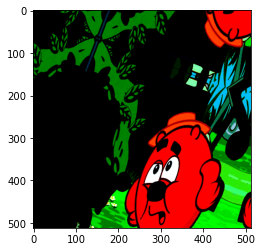

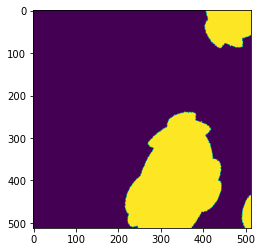

In [145]:
idx = 0
prev = test_dataset[idx]
rtt = prev[1].detach().numpy()
prev = torch.permute(prev[0], (1,2,0)).detach().numpy()
plt.imshow(prev)
plt.show()
plt.imshow(rtt)
plt.show()

In [146]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [147]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images).squeeze(1)
        output = torch.reshape(output, (output.shape[0],output.shape[1],output.shape[2],1))
        loss = criterion(output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [148]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images)
            image = output[0,:,:,:]
            rshpd = image.reshape(image.shape[1],image.shape[2],image.shape[0]).cpu().detach().numpy()
            rshpd = (rshpd>= 0.5) * 1
            output = torch.reshape(output, (output.shape[0],output.shape[2],output.shape[3],1))
            loss = criterion(output, target)
            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
        plt.imshow(rshpd)
        plt.show()

In [149]:
def train_and_validate(model, train_dataset, val_dataset, params):
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    criterion = nn.BCEWithLogitsLoss().to(params["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    for epoch in range(1, params["epochs"] + 1):
        train(train_loader, model, criterion, optimizer, epoch, params)
        validate(val_loader, model, criterion, epoch, params)
    return model

In [150]:
params = {
    "model": "UNet11",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 4,
    "num_workers": 0,
    "epochs": 100,
}

Epoch: 1. Validation. Loss: 192.981: 100%|███████████████████████████████████████████████| 4/4 [00:00<00:00,  4.90it/s]


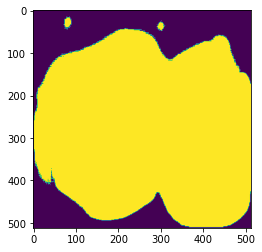

Epoch: 2. Validation. Loss: 0.239: 100%|█████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.80it/s]


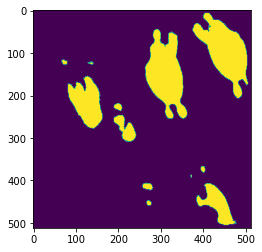

Epoch: 3. Validation. Loss: 0.279: 100%|█████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.92it/s]


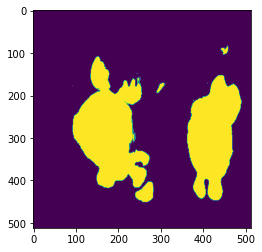

Epoch: 4. Validation. Loss: 0.215: 100%|█████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.94it/s]


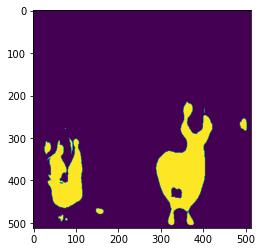

Epoch: 5. Validation. Loss: 0.217: 100%|█████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.98it/s]


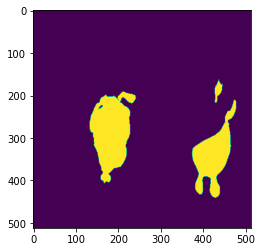

Epoch: 6. Validation. Loss: 0.152: 100%|█████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.03it/s]


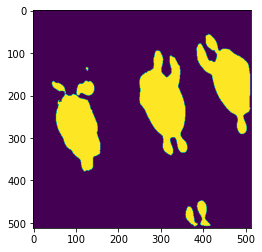

Epoch: 7. Validation. Loss: 0.160: 100%|█████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.93it/s]


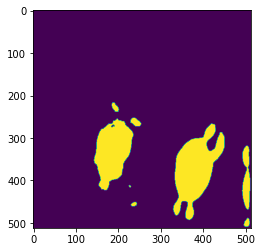

Epoch: 8. Validation. Loss: 0.159: 100%|█████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.73it/s]


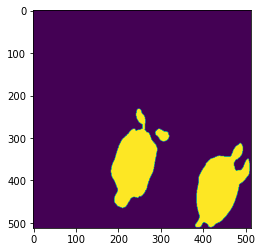

Epoch: 9. Validation. Loss: 0.128: 100%|█████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.91it/s]


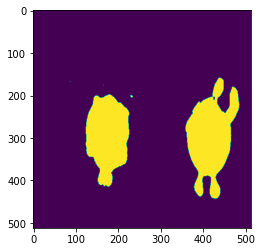

Epoch: 10. Validation. Loss: 0.364: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.91it/s]


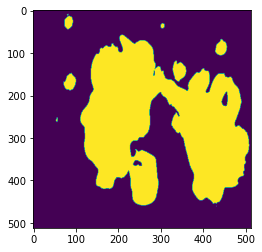

Epoch: 11. Validation. Loss: 0.236: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]


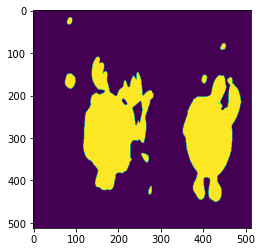

Epoch: 12. Validation. Loss: 0.145: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.92it/s]


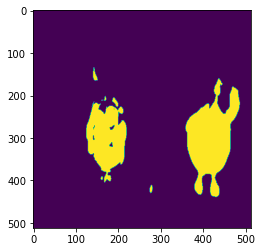

Epoch: 13. Validation. Loss: 0.166: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.88it/s]


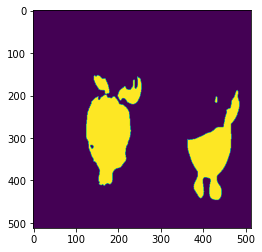

Epoch: 14. Validation. Loss: 0.181: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.96it/s]


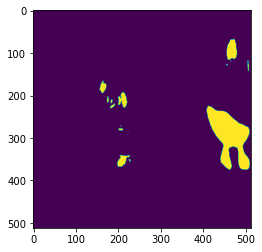

Epoch: 15. Validation. Loss: 0.109: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.97it/s]


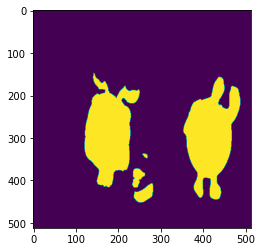

Epoch: 16. Validation. Loss: 0.099: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.98it/s]


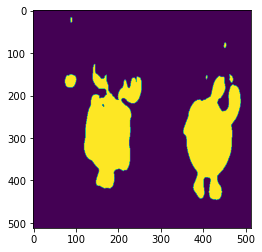

Epoch: 17. Validation. Loss: 0.122: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.92it/s]


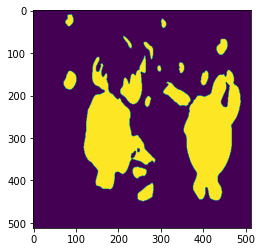

Epoch: 18. Validation. Loss: 0.084: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.82it/s]


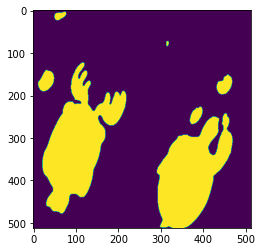

Epoch: 19. Validation. Loss: 0.067: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.91it/s]


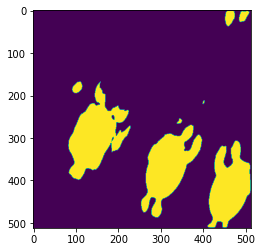

Epoch: 20. Validation. Loss: 0.084: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.88it/s]


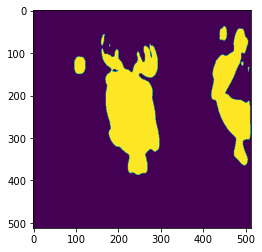

Epoch: 21. Validation. Loss: 0.076: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.95it/s]


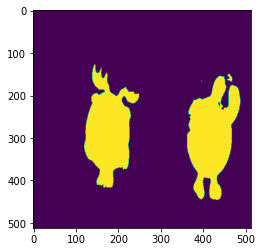

Epoch: 22. Train.      Loss: 0.096:  18%|████████▎                                      | 6/34 [00:02<00:11,  2.51it/s]


KeyboardInterrupt: 

In [151]:
model = train_and_validate(model, train_dataset, test_dataset, params)

In [152]:
def predict(model, params, test_dataset, batch_size, largen = 0.5):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=params["num_workers"], pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, filename in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= largen).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask in predicted_masks:
                predictions.append(predicted_mask)
    return predictions

In [153]:
final_dataset = SmeshMattingPredict(file_names, './target', predict_transform)

In [160]:
res = predict(model, params, final_dataset, 1, 0.3)

In [155]:
file_names = list(os.listdir('gt'))[1:]

In [91]:
file_names

['1.png',
 '10.png',
 '100.png',
 '101.png',
 '102.png',
 '103.png',
 '104.png',
 '105.png',
 '106.png',
 '107.png',
 '108.png',
 '109.png',
 '11.png',
 '110.png',
 '111.png',
 '112.png',
 '113.png',
 '114.png',
 '115.png',
 '116.png',
 '117.png',
 '118.png',
 '119.png',
 '12.png',
 '120.png',
 '121.png',
 '122.png',
 '123.png',
 '124.png',
 '125.png',
 '126.png',
 '127.png',
 '128.png',
 '129.png',
 '13.png',
 '130.png',
 '14.png',
 '15.png',
 '16.png',
 '17.png',
 '18.png',
 '19.png',
 '2.png',
 '20.png',
 '21.png',
 '22.png',
 '23.png',
 '24.png',
 '25.png',
 '26.png',
 '27.png',
 '28.png',
 '29.png',
 '3.png',
 '30.png',
 '31.png',
 '32.png',
 '33.png',
 '34.png',
 '35.png',
 '36.png',
 '37.png',
 '38.png',
 '39.png',
 '4.png',
 '40.png',
 '41.png',
 '42.png',
 '43.png',
 '44.png',
 '45.png',
 '46.png',
 '47.png',
 '48.png',
 '49.png',
 '5.png',
 '50.png',
 '51.png',
 '52.png',
 '53.png',
 '54.png',
 '55.png',
 '56.png',
 '57.png',
 '58.png',
 '59.png',
 '6.png',
 '60.png',
 '61.pn

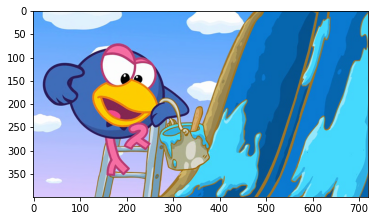

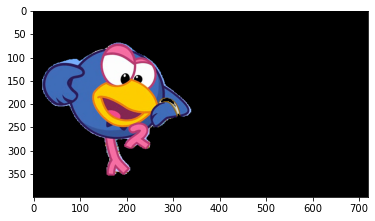

In [162]:
idx = 148
mask = res[idx]
pic = final_dataset[idx][1]
trans = A.Resize(pic.shape[0],pic.shape[1])
mask = trans(image = mask)
mask = mask["image"]

plt.imshow(pic)
plt.show()
stacked = (mask > 0)
plt.imshow(np.dstack((stacked,stacked,stacked)) * pic)
plt.show()